# Bank Marketing <img src="./images/dataset-cover.PNG" width="400"  align="right"/> 
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The following information is drawn from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/bank+marketing

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Preparing Data for Analysis](#2)
  - [ 2.1 Dataload Dataset](#2.1)
  - [ 2.2 Feuture engineering](#2.2)
  - [ 2.3 Scaling & Encoding](#2.3)
- [ 3 - Principal Component Analysis](#3)
- [ 4 - Modeling](#4)
  - [ 4.1 Logistic regression](#4.1)
  - [ 4.2 Boosted trees - XGBoost](#4.2)
  - [ 4.2 Recall (Logistic regression & XGBoost)](#4.3)  
- [ 5 - Evaluation of Machine Learning](#5)  
- [ 6 - Neural Networks](#6)
- [ 7 - Evaluation of Neural Networks](#7) 

<a name="1"></a>
## Packages

* Machine Learning - Unsupervised Learning (PCA, k-means-clustering)
* Machine Learning - Supervised Learning (Logistic regression, XGBooster)
* Tensorflow and Keras - Convolutional neural network

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.colors as mc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('./deeplearning.mplstyle')
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import  cross_val_predict
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
import keras
from lib.utils_common import *
from lib.cnn_keras import build_model, k_fold
from joblib import dump, load
from pathlib import Path  

<a name="2"></a>
## Preparing Data for Analysis

In [41]:
path_lr = os.getcwd() + '\models\log_reg.joblib'
path_xgb = os.getcwd() + '\models\log_xgb.joblib'
path_df_cnn = Path(os.getcwd() + '\data\df_cnn_res.csv')

<a name="2.1"></a>
### Dataload Dataset

In [3]:
data  = pd.read_csv("data/bank-additional-full.csv", sep = ";",keep_default_na = False)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
data.isnull().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [6]:
data.describe(include = 'all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


<a name="2.2"></a>
## Feuture engineering

In [5]:
# Check for missings
print(len(data.columns[data.isna().any()])/len(data.columns))
print(data.isnull().sum().sum()/np.product(data.shape))

0.0
0.0


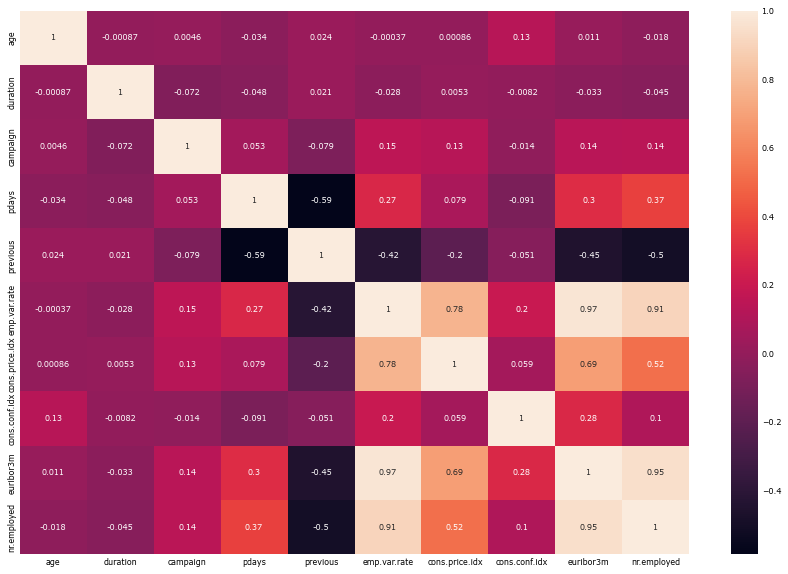

In [8]:
corrMatrix = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [6]:
y_data = data['y']
X_data = data.drop(['y'],axis = 1)

<a name="2.3"></a>
## Scaling & Encoding

In [7]:
X_data = pd.get_dummies(X_data) # Encoding

In [8]:
mm_scale = preprocessing.MinMaxScaler() # Scaling
X_data[X_data.columns] = mm_scale.fit_transform(X_data[X_data.columns])

In [ ]:
#mm_scale = preprocessing.Normalizer().fit(X_data)
#X_data[X_data.columns] = mm_scale.fit_transform(X_data[X_data.columns])

In [9]:
def y_val(x):
    if x == 'no':
        return 0
    elif x == 'yes':
        return 1
y_data = y_data.apply(y_val)    

In [10]:
# Split the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.35,
                                                    random_state = 42)

<a name="3"></a>
## Principal Component Analysis

In [11]:
# PCA
#Train data
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_train_reduced = pca.fit_transform(X_train)
# Test Data
pca = PCA(n_components = 3)
X_test_reduced = pca.fit_transform(X_test)
X_train_reduced.shape,X_test_reduced.shape

((26772, 3), (14416, 3))

In [12]:
print(pca.explained_variance_)                                    # absolute values
print(pca.explained_variance_ratio_)                              # percentage values

[0.73899811 0.47961706 0.43938529]
[0.12050623 0.07820973 0.07164926]


<a name="4"></a>
## Modeling

<a name="4.1"></a>
### Logistic regression

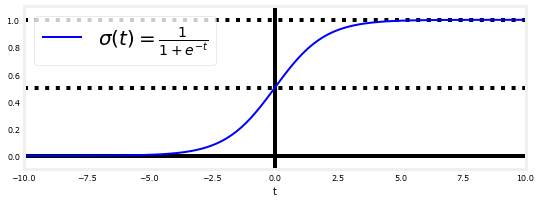

In [16]:
log_reg_func()

In [13]:
log_reg = LogisticRegression(multi_class = 'ovr',
             class_weight = None, 
             solver= 'saga', 
             max_iter = 10000)

In [14]:
log_reg.fit(X_train_reduced,y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', solver='saga')

In [23]:
#y_cla_pred = log_reg.predict_proba(X_test_reduced)[:, 1]

In [15]:
log_reg.score(X_test_reduced, y_test)# The accuracy for the test data set

0.8867230854605993

In [16]:
y_probas_log_reg = cross_val_predict(log_reg,X_test_reduced, y_test,cv=3, method="predict_proba" )
probs_lr = y_probas_log_reg[:,1]

In [17]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs_lr)

<a name="4.2"></a>
###  Boosted trees - XGBoost

In [18]:
log_xgb = XGBClassifier(learning_rate = 0.01, n_estimators = 100,objective='binary:logistic',
                     booster = 'gbtree', scale_pos_weight = 1)
log_xgb.fit(X_train_reduced,y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [19]:
y_pred = log_xgb.predict(X_test_reduced)
log_xgb.score(X_test_reduced, y_test)# The accuracy for the test data set

0.8864456159822419

<a name="4.3"></a>
### Recall (Logistic regression & XGBoost)

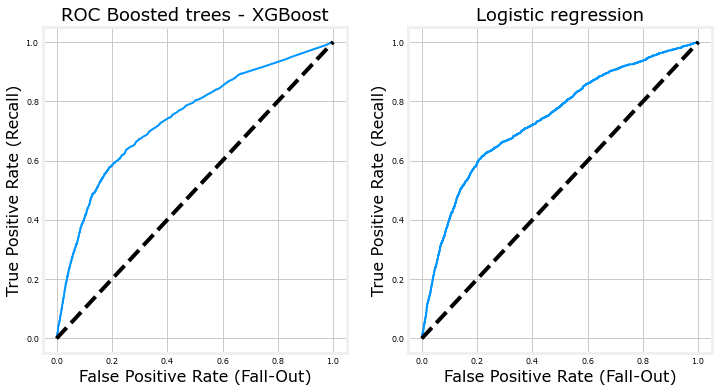

In [20]:
y_probas_xgb = cross_val_predict(log_xgb,X_test_reduced, y_test,cv=3, method="predict_proba" )
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probas_xgb[:,1])
plot_roc_lr_xgb(fpr_xgb, tpr_xgb, fpr_lr, tpr_lr)

In [50]:
if not os.path.isfile(path_lr):
    dump(log_reg, path_lr) 
    print('Saved trained model at %s ' % path_lr)

Saved trained model at C:\Users\Burlay\Desktop\Jupyter_vm\uci-bank-marketing\models\log_reg.joblib 


In [31]:
if not os.path.isfile(path_xgb):
    dump(path_xgb,path_xgb)
    print('Saved trained model at %s ' % path_xgb)

In [32]:
xgb_clf = load(path_xgb)
y_xgb_pred = probability(X_test_reduced, y_test,log_reg)
y_xgb_pred[y_xgb_pred['Yes/No'] > 0]

,ID,Yes/No,YesProbabil,Predicted
12,13595,1,0.132803,0
13,21871,1,0.078866,0
19,37480,1,0.365294,0
20,17267,1,0.027502,0
22,8528,1,0.042751,0
...,...,...,...,...
14379,27958,1,0.050107,0
14389,39183,1,0.059248,0
14396,40567,1,0.172782,0
14405,30322,1,0.203068,0


<a name="5"></a>
## Evaluation of Machine Learning

In [26]:
ml_models_acc(X_train_reduced,X_test_reduced,y_train,y_test)

Decision Tree Classifier CV Accuracy: 0.8815182065853362
Extreme Gradient Boosing CV Accuracy: 0.8874945231485697
Support Vector Machines CV Accuracy: 0.887718515123644
K-Nearest Neighbors CV Accuracy: 0.8818914521355797
Logistic Regression CV Accuracy: 0.887718515123644


Decision Tree Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     12782
           1       0.23      0.03      0.05      1634

    accuracy                           0.88     14416
   macro avg       0.56      0.51      0.49     14416
weighted avg       0.81      0.88      0.84     14416



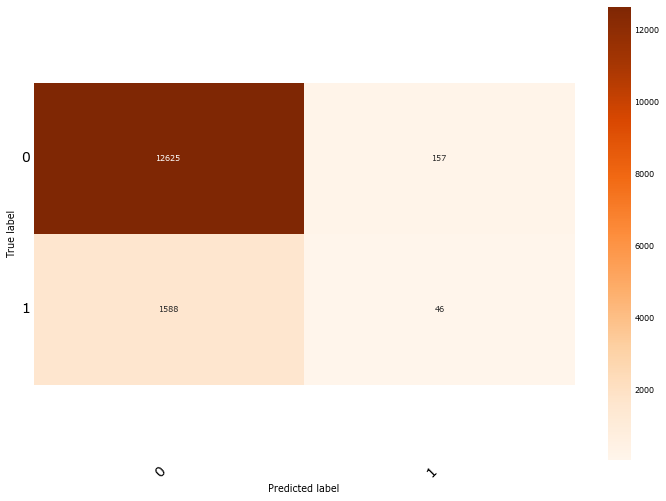

Decision Tree Classifier

Train Stats
               precision    recall  f1-score   support

           0       0.90      1.00      0.94     23766
           1       0.72      0.09      0.15      3006

    accuracy                           0.89     26772
   macro avg       0.81      0.54      0.55     26772
weighted avg       0.88      0.89      0.85     26772



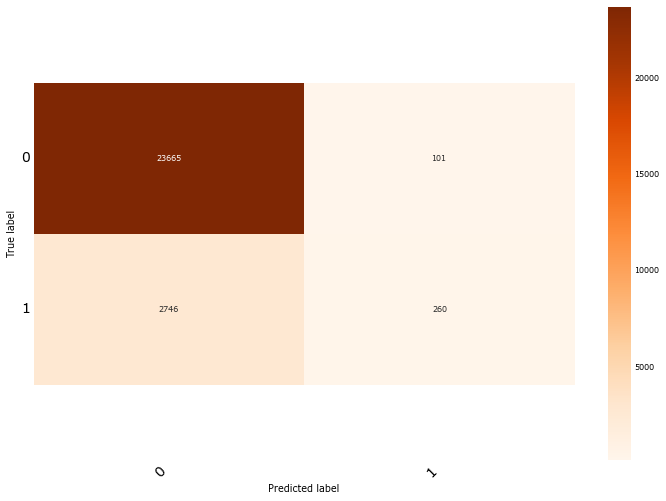

Extreme Gradient Boosing

Test Stats
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     12782
           1       0.11      0.00      0.00      1634

    accuracy                           0.89     14416
   macro avg       0.50      0.50      0.47     14416
weighted avg       0.80      0.89      0.83     14416



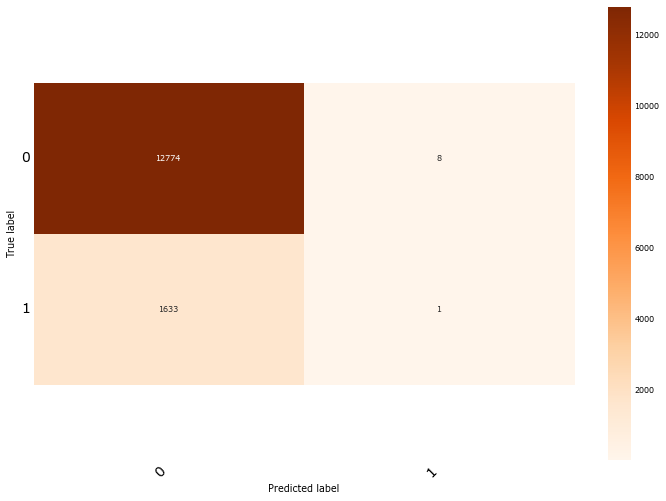

Extreme Gradient Boosing

Train Stats
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     23766
           1       0.82      0.04      0.08      3006

    accuracy                           0.89     26772
   macro avg       0.86      0.52      0.51     26772
weighted avg       0.88      0.89      0.85     26772



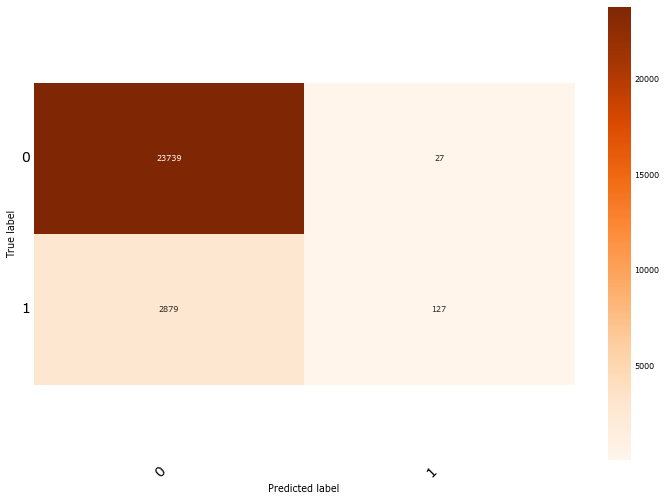

Support Vector Machines

Test Stats
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     12782
           1       0.00      0.00      0.00      1634

    accuracy                           0.89     14416
   macro avg       0.44      0.50      0.47     14416
weighted avg       0.79      0.89      0.83     14416



c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

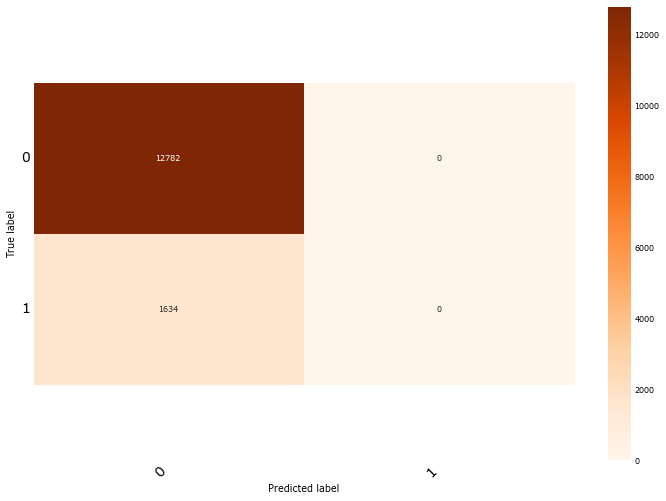

Support Vector Machines


c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,


Train Stats
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     23766
           1       0.00      0.00      0.00      3006

    accuracy                           0.89     26772
   macro avg       0.44      0.50      0.47     26772
weighted avg       0.79      0.89      0.83     26772



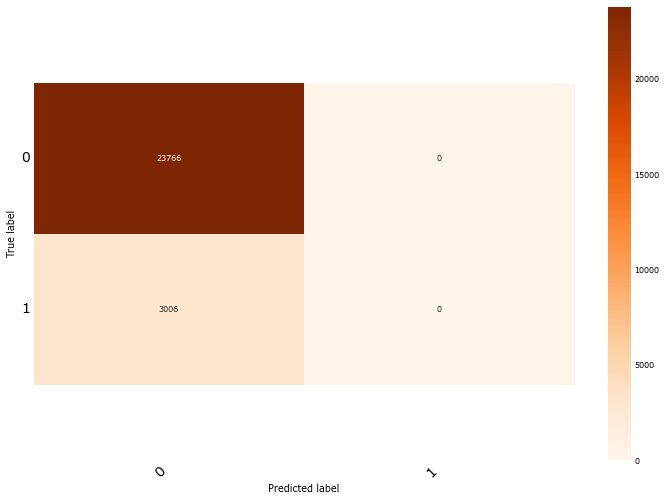

K-Nearest Neighbors

Test Stats
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     12782
           1       0.26      0.03      0.05      1634

    accuracy                           0.88     14416
   macro avg       0.58      0.51      0.49     14416
weighted avg       0.82      0.88      0.84     14416



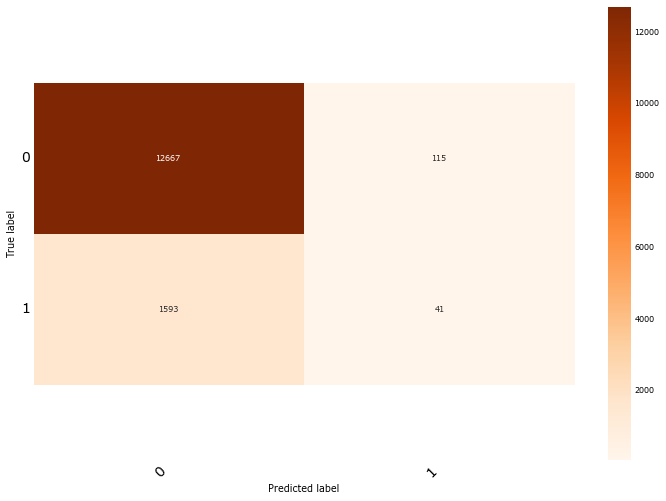

K-Nearest Neighbors

Train Stats
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23766
           1       1.00      1.00      1.00      3006

    accuracy                           1.00     26772
   macro avg       1.00      1.00      1.00     26772
weighted avg       1.00      1.00      1.00     26772



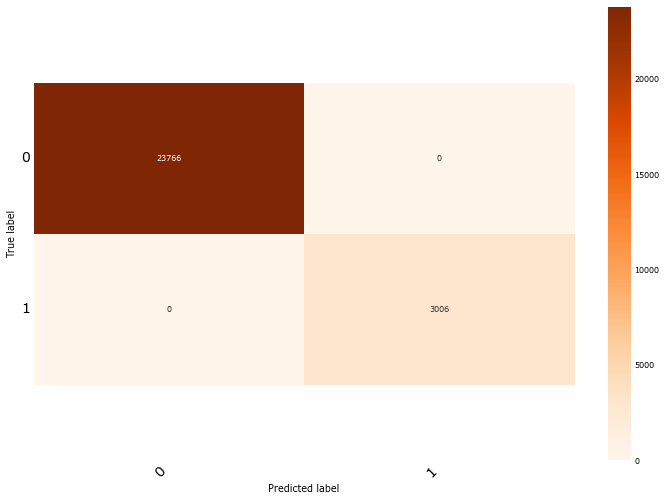

Logistic Regression

Test Stats
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     12782
           1       0.57      0.00      0.00      1634

    accuracy                           0.89     14416
   macro avg       0.73      0.50      0.47     14416
weighted avg       0.85      0.89      0.83     14416



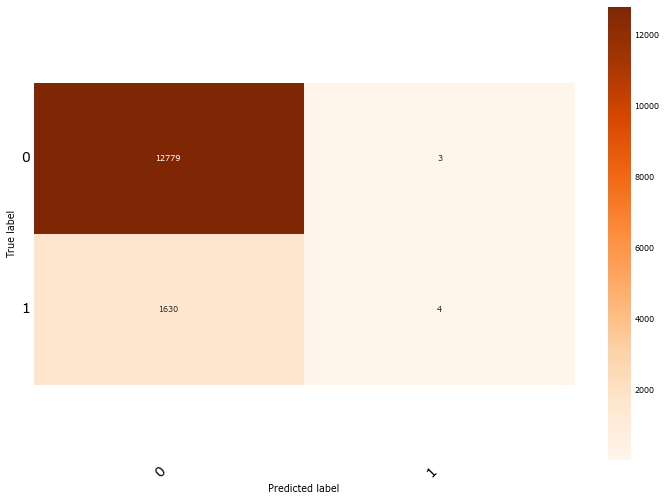

Logistic Regression

Train Stats
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     23766
           1       0.00      0.00      0.00      3006

    accuracy                           0.89     26772
   macro avg       0.44      0.50      0.47     26772
weighted avg       0.79      0.89      0.83     26772



c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\burlay\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

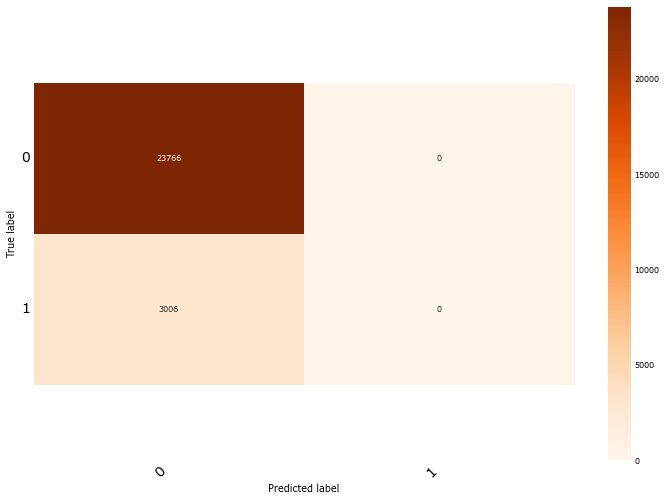

In [27]:
ml_models_eval(X_train_reduced,X_test_reduced,y_train,y_test)

<a name="6"></a>
## Neural Networks

In [22]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [23]:
x_traincnn = X_train
x_testcnn = X_test

In [ ]:
#x_traincnn = np.expand_dims(X_train, axis=2)
#x_testcnn = np.expand_dims(X_test, axis=2)
#x_traincnn.shape,x_testcnn.shape

In [24]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 63, 128)           768       
                                                                 
 activation (Activation)     (None, 63, 128)           0         
                                                                 
 dropout (Dropout)           (None, 63, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            82048     
                                                                 
 activation_1 (Activation)   (None, 7, 128)            0         
                                                        

In [25]:
#K-fold validation
model,cnnhistory = k_fold(4,x_traincnn,x_testcnn,y_train,y_test)

Processing fold #0
Restored model, accuracy: 90.99% loss:0.1899799257516861
Processing fold #1
Restored model, accuracy: 90.33% loss:0.19711939990520477
Processing fold #2
Restored model, accuracy: 91.24% loss:0.18753699958324432
Processing fold #3
Restored model, accuracy: 90.74% loss:0.2055148333311081
451/451 [==============================] - 1s 2ms/step - loss: 0.1984 - acc: 0.9056
Restored model, accuracy: 90.56%


<a name="7"></a>
## Evaluation of Neural Networks

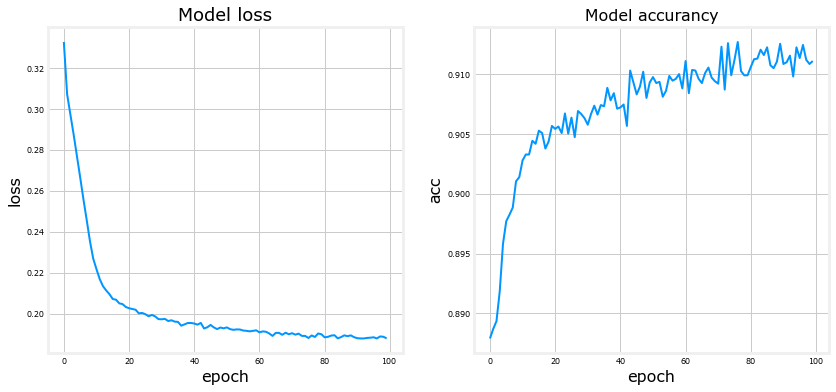

In [42]:
plot_acc_loss(cnnhistory.history)

In [27]:
path_dir = os.getcwd() + '\models\cnn_model.h5'
# save the model to disk
if not os.path.isfile(path_dir):
    model.save(path_dir)
    print('Saved trained model at %s ' % path_dir)

In [43]:
model_cnn = keras.models.load_model(path_dir )
df_cnn_res = probability(x_testcnn,y_test,model_cnn)

451/451 [==============================] - 1s 2ms/step


<AxesSubplot:xlabel='Predicted', ylabel='count'>

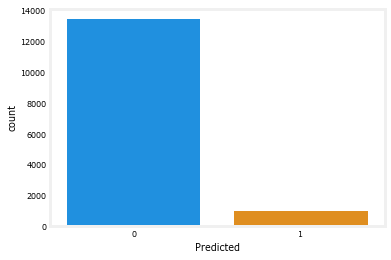

In [44]:
sns.countplot(x='Predicted', data=df_cnn_res)

<AxesSubplot:xlabel='Yes/No', ylabel='count'>

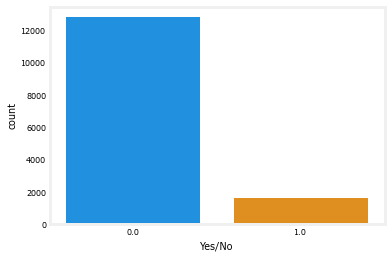

In [45]:
sns.countplot(x='Yes/No', data=df_cnn_res)

In [46]:
df_cnn_res[df_cnn_res['Yes/No'] >0].head(10)

,ID,Yes/No,YesProbabil,Predicted
12,13595,1.0,0.518044,1
13,21871,1.0,0.261340,0
19,37480,1.0,0.510612,1
20,17267,1.0,0.560135,1
22,8528,1.0,0.150378,0
31,36562,1.0,0.317219,0
32,40868,1.0,0.689358,1
33,14050,1.0,0.437856,0
34,10835,1.0,0.260211,0
42,41020,1.0,0.678171,1


In [47]:
df_cnn_res

,ID,Yes/No,YesProbabil,Predicted
0,32884,0.0,0.229932,0
1,3169,0.0,0.000317,0
2,32206,0.0,0.001766,0
3,9403,0.0,0.006801,0
4,14020,0.0,0.001418,0
...,...,...,...,...
14411,30159,1.0,0.589004,1
14412,38385,0.0,0.371762,0
14413,11679,0.0,0.000300,0
14414,31892,0.0,0.002972,0


In [48]:
df_cnn_res.to_csv(path_df_cnn)